# Create a PPI plot from Sigmet files available on AWS using Xradar 
This example show how to access radar from the Colombian National radar network availble on Amazon Web Services. We will look at the bucket structure a finally plot PPI using xradar library. Radar reflectivity will be filtered using some polarimetric values and xarray functionality.
## Imports

In [34]:
import pyart
import fsspec
import xarray as xr
import xradar as xd
import boto3
import botocore
import numpy as np
from pandas import to_datetime
import matplotlib.pyplot as plt
from botocore.client import Config
from datetime import datetime
from matplotlib import pyplot
# pyplot.style.use('dark_background')

## IDEAM AWS Bucket
Instituto de Hidrología, Meteorología y Estudios Ambientales - IDEAM (Colombian National Weather Service) has made public the weather radar data. Data can be found [here](https://registry.opendata.aws/ideam-radares/) and documentation [here](http://www.pronosticosyalertas.gov.co/archivos-radar#:~:text=La%20red%20de%20radares%20de%20IDEAM) 

Bucket structure is  *s3://s3-radaresideam/l2_data/YYYY/MM/DD/Radar_name/RRRAAMMDDTTTTTT.RAWXXXX*
where:
 * *YYYY* is the 4 digit year 
 * *MM* is the 2 digit month
 * *DD* is the 2 digit day
 * *Radar_name* radar name. Options are Guaviare, Munchique, Barranca, Carimagua
 * *RRRAAMMDDTTTTTT.RAWXXXX* is the radar filename with:
     - RRR three firs leters if the radar name (e.g. GUA for Guaviare radar)
     - YY is the 2 digit year 
     - MM is the 2 digit month
     - DD is the 2 digit day
     - TTTTTT is the time at which the scan was made (GTM)
     - RAWXXXX sigmet file format and unique coude provide by IRIS software
     
This seems to be too complicated! No worries, we created a function that can help you out with listing files within the bucket

In [2]:
def create_query(date, radar_site):
    """
    Creates a string for quering the IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a IDEAM radar bucket format
    """
    return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'

Let suppose we want to check the radar files on **2022-10-6** from Guaviare radar

In [3]:
date_query = datetime(2022, 10, 6)
radar_name = "Guaviare" 
query = create_query(date=date_query, radar_site=radar_name)
query

'l2_data/2022/10/06/Guaviare/GUA221006'

### Conecting to the AWS bucket
Once the query is define we can procced to list all the available files in the bucket using **boto3** and **botocore** libraries

In [4]:
str_bucket = 's3://s3-radaresideam/'
s3 = boto3.resource('s3',
                    config=Config(signature_version=botocore.UNSIGNED, 
                                  user_agent_extra='Resource'))

bucket = s3.Bucket('s3-radaresideam')

radar_files = [f'{str_bucket}{i.key}' for i in bucket.objects.filter(Prefix=f"{query}")]
radar_files[:5]

['s3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000012.RAWHDKV',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000116.RAWHDL6',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000248.RAWHDL9',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000327.RAWHDLH',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000432.RAWHDLL']

## Let's open one of  these files using Xradar

We can use the Filesystem interfaces for Python [fsspec](https://filesystem-spec.readthedocs.io/en/latest/) to access the data from the s3 bucket

In [5]:
file = fsspec.open_local(f'simplecache::{radar_files[0]}', s3={'anon': True}, filecache={'cache_storage': '.'})

In [6]:
ds = xr.open_dataset(file, engine='iris', group='sweep_0')

IDEAM radar data is storage in the AWS bucket as one file per sweep. Therefore, use only *'sweep_0'*  under the group argument.

In [7]:
ds

<xarray.Dataset>
Dimensions:            (azimuth: 720, range: 994)
Coordinates:
  * azimuth            (azimuth) float64 0.02747 0.5191 1.024 ... 359.0 359.5
    elevation          (azimuth) float32 ...
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables: (12/17)
    DBTH               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    ...                 ...
    DB_DBZE8           (azimuth, range) int16 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

## Reflectivity ($Z$) and Correlation coefficient ($\rho_{HV}$) plot


/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))


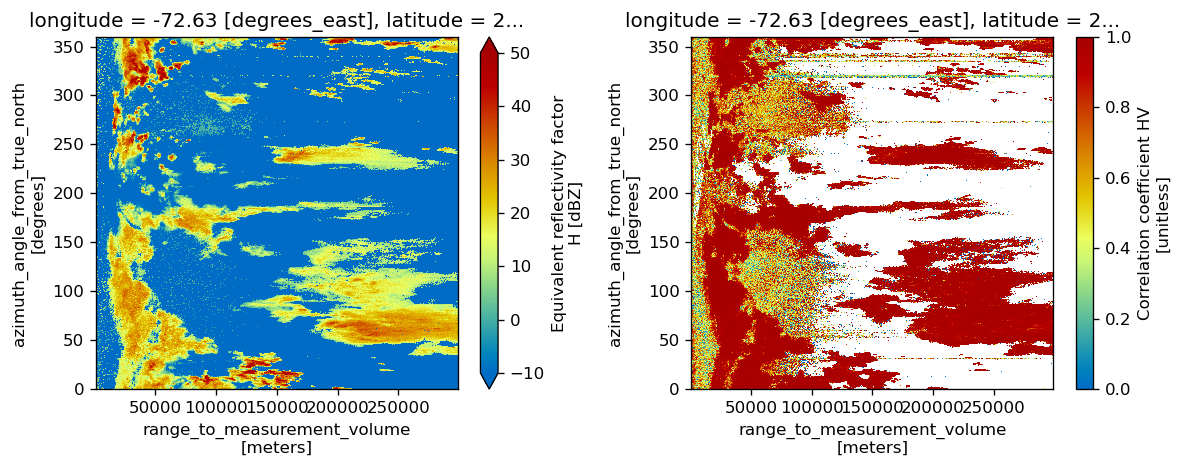

In [8]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
ds.DBZH.plot(cmap='pyart_HomeyerRainbow', vmin=-10, vmax=50, ax=ax)
ds.RHOHV.plot(cmap='pyart_HomeyerRainbow', vmin=0, vmax=1, ax=ax1)
fig.tight_layout()

Dataset object has range and azimuth as coordinates. To create a polar plot we need to add the georeference information using  `xd.georeference.get_x_y_z(ds)` module from [xradar](https://docs.openradarscience.org/projects/xradar/en/stable/index.html)

In [9]:
ds = xd.georeference.get_x_y_z(ds)
ds

<xarray.Dataset>
Dimensions:            (azimuth: 720, range: 994)
Coordinates:
  * azimuth            (azimuth) float64 0.02747 0.5191 1.024 ... 359.0 359.5
    elevation          (azimuth) float64 0.4834 0.4834 0.4834 ... 0.4834 0.4834
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    longitude          float64 -72.63
    latitude           float64 2.534
    altitude           float64 240.0
    spatial_ref        int64 0
    x                  (azimuth, range) float64 0.4793 0.6231 ... -2.491e+03
    y                  (azimuth, range) float64 999.9 1.3e+03 ... 2.987e+05
    z                  (azimuth, range) float64 248.5 251.1 ... 8.011e+03
Data variables: (12/17)
    DBTH               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    ...                 ...
    DB_DBZE8           (azimuth, range) int16 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

Now x, y, and z have been added to the dataset coordinates. Let's create the new plot using the georeference information 

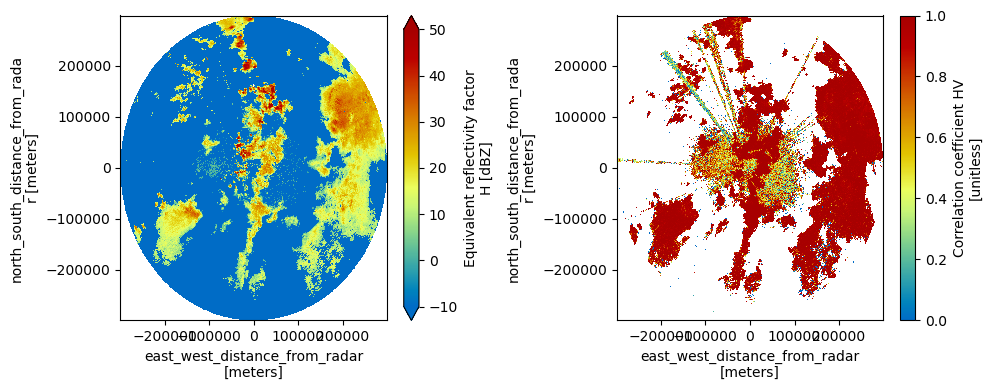

In [10]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ds.DBZH.plot(x='x', y='y', cmap='pyart_HomeyerRainbow', vmin=-10, vmax=50, ax=ax)
ds.RHOHV.plot(x='x', y='y', cmap='pyart_HomeyerRainbow', vmin=0, vmax=1, ax=ax1)
ax.set_title('')
ax1.set_title('')
fig.tight_layout()

## Let's clean the plots using [`xarray.where`](https://docs.xarray.dev/en/stable/generated/xarray.where.html) module

The blue background color indicates that the radar reflectivity is less than -10 dBZ. we can filter them out as follows

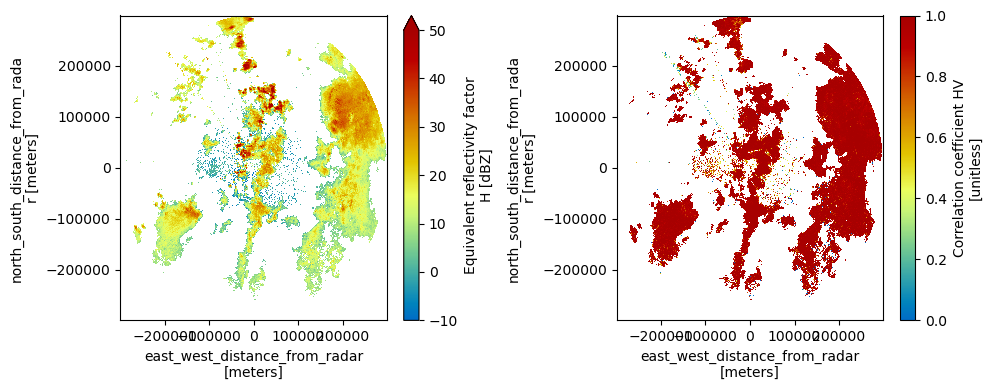

In [11]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ds.DBZH.where(ds.DBZH >=-10).plot(x='x', y='y', cmap='pyart_HomeyerRainbow', vmin=-10, vmax=50, ax=ax)
ds.RHOHV.where(ds.DBZH >=-10).plot(x='x', y='y', cmap='pyart_HomeyerRainbow', vmin=0, vmax=1, ax=ax1)
ax.set_title('')
ax1.set_title('')
fig.tight_layout()

Polarimetric variables can also be used as indicators to remove different noise from different sources. For example, the $\rho_{HV}$ provides a measure of the consistency of the shapes and sizes of targets within the radar beam. Thus, the grater the $\rho_{HV}$ the more consistent is the measurament. For this example we can use $\rho_{HV} > 0.85$ as an acceptable threshold 

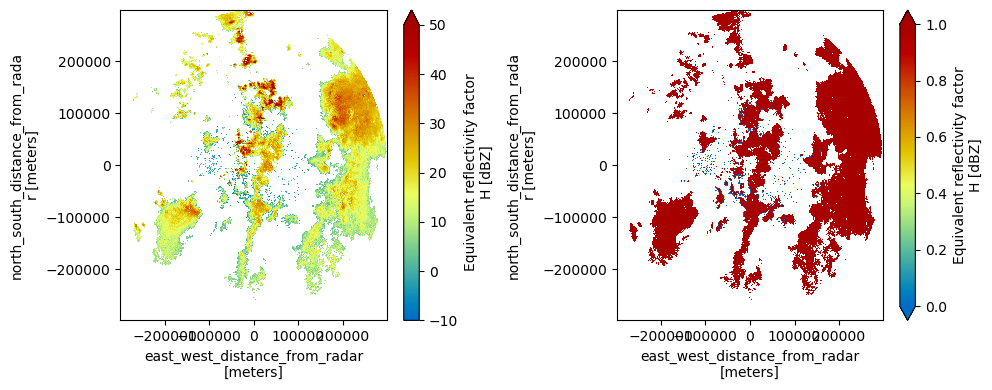

In [12]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ds.DBZH.where(ds.DBZH >=-10).where(ds.RHOHV >=0.85).plot(x='x', y='y', cmap='pyart_HomeyerRainbow', 
                                                        vmin=-10, vmax=50, ax=ax)

ds.DBZH.where(ds.DBZH >=-10).where(ds.RHOHV >=0.85).plot(x='x', y='y', cmap='pyart_HomeyerRainbow', 
                                                        vmin=0, vmax=1, ax=ax1)
ax.set_title('')
ax1.set_title('')
fig.tight_layout()

## Embelishing the plots
We can change some axis labels as well as the color bar label to make the plot more understantable

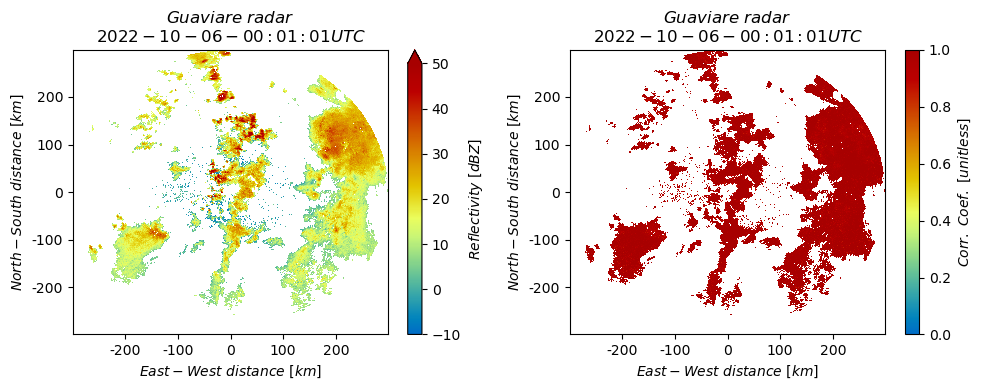

In [36]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ds.DBZH.where(ds.DBZH >=-10).where(ds.RHOHV >=0.85).plot(x='x', y='y', cmap='pyart_HomeyerRainbow', 
                                                         vmin=-10, vmax=50, ax=ax, 
                                                         cbar_kwargs={'label': '$Reflectivity \ [dBZ]$'})

ds.RHOHV.where(ds.DBZH >=-10).where(ds.RHOHV >=0.85).plot(x='x', y='y', cmap='pyart_HomeyerRainbow', 
                                                        vmin=0, vmax=1, ax=ax1,
                                                         cbar_kwargs={'label': '$Corr. \ Coef. \  [unitless]$'})

# lambda fucntion for unit trasformation m->km
m2km = lambda x, _: f'{x/1000:g}'
# set new ticks
ax.xaxis.set_major_formatter(m2km)
ax.yaxis.set_major_formatter(m2km)
ax1.xaxis.set_major_formatter(m2km)
ax1.yaxis.set_major_formatter(m2km)
# removing the title in both plots
ax.set_title('')
ax1.set_title('')

# renaming the axis
ax.set_ylabel('$North - South \ distance \ [km]$')
ax.set_xlabel('$East - West \ distance \ [km]$')
ax1.set_ylabel('$North - South \ distance \ [km]$')
ax1.set_xlabel('$East - West \ distance \ [km]$')

# setting up the title
ax.set_title(f'$Guaviare \ radar$' + '\n' + f'${to_datetime(ds.time.values[0]): %Y-%m-%d - %X}$' + "$ UTC$")
ax1.set_title(f'$Guaviare \ radar$' + '\n' + f'${to_datetime(ds.time.values[0]): %Y-%m-%d - %X}$' + "$ UTC$")
fig.tight_layout()